This notebook has histograms of the following:
1. Sus scrofa full database probability density distribution
2. Sus scrofa proteome database probability density distribution
3. Sus scrofa full and proteome database unnormalized distributions
4. Homo sapien full and proteome probability density distributions
5. Homo sapien full and proteome unnormalized distributions

The purpose of this notebook is to make observations on protein length and what about protein length characterizes an "unreliable" protein sequence

What to work on:
> Alter the bin width of some sus scrofa and homo sapien distributions



In [ ]:
# Connect notebook to Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Navigate to the shared drive folder
%cd /content/drive/'My Drive'/'Pig Proteomics Summer Project'
!pwd
!ls

/content/drive/.shortcut-targets-by-id/1H3M9nQYJ9K9M22jDv-wcvZ0azPz9lhsr/Pig Proteomics Summer Project
/content/drive/.shortcut-targets-by-id/1H3M9nQYJ9K9M22jDv-wcvZ0azPz9lhsr/Pig Proteomics Summer Project
'2021-06-21 Introduction to Proteomes.ipynb'
'2021-06-28 Reactome and Uniprot.ipynb'
'2021-06-29 Identifying characteristics of an unreliable protein.gslides'
'Copy of gene_PE.ipynb'
 data
 gene_PE.ipynb
 histogram.ipynb
 output
 pe_scores.ipynb
 scratch
'Summer Project.gdoc'
'Week 1 Introduction slides.gslides'
'Week 3 Findings.gslides'


In [ ]:
%cd data

/content/drive/.shortcut-targets-by-id/1H3M9nQYJ9K9M22jDv-wcvZ0azPz9lhsr/Pig Proteomics Summer Project/data


In [ ]:
#unzipping the sus scrofa proteins with low confidence (120,926)
! gunzip all_human_and_isoforms.fasta.gz

In [ ]:
!pip install fastaparser

# **FUNCTIONS**

In [ ]:
import fastaparser
import matplotlib.pyplot as plt
import pandas as pd
from itertools import groupby
from random import sample
import numpy as np
from itertools import chain, combinations

def parse_fasta_file(file_name):
  """
  this function parses a FASTA database and returns it as a mapping from the
  header of the protein to the amino acid sequence it corresponds to
  mapping: {header: sequence}
  """
  out_dict = {}
  fastaRaw = [] #uses quick parsing method
  with open(file_name) as fasta_file:
      parserQuick = fastaparser.Reader(fasta_file, parse_method = 'quick')
      
      for seq in parserQuick:
          fastaRaw.append(seq)
          
  headerList = []
  seqList = []

  for k in fastaRaw:
      headerList.append(k.header)
      seqList.append(k.sequence)

  if len(headerList) != len(seqList):
      raise ValueError("Number of headers =/= number of sequences")

  for i in range(len(headerList)):
      out_dict[headerList[i]] = seqList[i]

  return out_dict

def fasta_to_table(file_name):
    """
    creates function which accepts a FASTA file and returns dataframe in this format:
    SP or TR | Accession | Organism | Gene Name | Length
    --------------------------------------------------------
    if it is swissprot or trembl, accession, organism, its gene name, and length
    """
    header = ['sptr', 'Accession', 'Organism', 'Gene name', 'Length']
    sptr = []
    accession = []
    organism = []
    gene_name = []
    length = []
    fastaRaw = []
    PE_scores = []
    indice1 = 0 #indice for 'OS='
    indice2 = 0 #indice for 'OX='
    indice3 = 0 #indice for 'GN='
    indice4 = 0 #indice for 'PE='
    
    out_dict = parse_fasta_file(file_name)
    
    for key in out_dict.keys():
        indice1 = True #indice for 'OS='
        indice2 = True #indice for 'OX='
        indice3 = True #indice for 'GN='
        indice4 = True #indice for 'PE='
        indice5 = True #indice for 'SV='
        
        indice = []

        t1 = key[1:3] #sp or tr

        for j in range(len(key)):
            t_find = key[j:j+1]
            if t_find == '|':
                indice.append(j)
            else:
                pass
        
        t2 = key[indice[0]+1:indice[1]] #accession
        
        for k in range(len(key)):
            dummyText = key[k:k+3]
            if dummyText == 'OS=':
              indice1 = k
            elif dummyText == 'OX=':
              indice2 = k
            elif dummyText == 'GN=':
              indice3 = k
            elif dummyText == 'PE=':
              indice4 = k
            elif dummyText == 'SV=':
              indice5 = k
            else:
                pass
        
        if indice3 == True:
          GNName = 'No Name'

        else:
          GNName = key[indice3+3:indice4]
          
        OSName = key[indice1+3:indice2]
        lengthCalc = len(out_dict[key])
        #PE = int(key[indice4+3:indice5])
        
        sptr.append(t1)
        accession.append(t2)
        organism.append(OSName)
        gene_name.append(GNName)
        length.append(lengthCalc)
        #PE_scores.append(PE)
        
    data = {'sptr' : sptr, 'accession' : accession, 'organism' : organism, 'Gene Name' : gene_name,
           'length' : length}
    df = pd.DataFrame(data)
    
    ''' how alex would have done it
        sub_table = fasta_table[fasta_table['GN'] == i]
        pig_list = set(sub_table[sub_table['organism'] == 'Sus scrofa']['accession])
        '''
    return df

def length_of_sequence(file_name):
  """
  compute length of each sequence in FASTA file
  """
  out_dict = parse_fasta_file(file_name)
  length_list = []

  for k in out_dict.keys():
    length_seq = len(out_dict[k])
    length_list.append(length_seq)
  
  return length_list


def swiss_prot_sequences(file_name):
  """
  only retrieves SP sequences from FASTA file inputted
  """
  out_dict = parse_fasta_file(file_name)
  sp_sequences = []

  for k in out_dict.keys():
    t = k[1:3]
    if t == 'sp':
      sp_sequences.append(out_dict[k])
    else:
      pass
  
  sp_lengths = []
  for j in sp_sequences:
    sp_lengths.append(len(j))
  
  return sp_lengths

def PE_score_length(file_name, pe_req = [1]):
  """
  extracts list of lengths where the PE score is 1 (default value)
  type: list
  """
  out_dict = parse_fasta_file(file_name)
  header_to_PE = {} #accession code to PE score
  length_list = []

  for key in out_dict.keys():    
    indice1 = None
    indice2 = None

    for k in range(len(key)):
      t = key[k:k+3]
      if t == 'PE=':
        indice1 = k
      elif t == 'SV=':
        indice2 = k
      else:
        pass
    
    header_to_PE[key] = int(key[indice1+3:indice2])
  
  for key in header_to_PE.keys():
    if (header_to_PE[key] in pe_req):
      length_list.append(len(out_dict[key]))
    else:
      pass
  
  return length_list

def extract_isoforms(fasta_table):
  """
  extracts only isoforms and its respective sequence lengths from fasta_table
  {accession codes : sequence lengths}
  """
  isoform_dict = {}
  accession_ids = list(fasta_table['accession'])

  for j in range(len(accession_ids)):
    if '-' in fasta_table['accession'].values[j]:
      isoform_dict[fasta_table['accession'].values[j]] = fasta_table['length'].values[j]
    else:
      pass
  
  return isoform_dict

def bin_to_accession(fasta_table, binwidth = 10):
  """
  {bin : [acccession IDs]}
  """
  accession_to_length = {}
  for i,j in zip(fasta_table['accession'], fasta_table['length']):
    accession_to_length[i] = j
  
  bins = range(min(accession_to_length.values()), max(accession_to_length.values()) + binwidth, binwidth)

  bin_to_accession = {}
  #for i,j in zip(list(bins), list(accession_to_length.keys())):
  for j in list(accession_to_length.keys()):
    for i in list(bins):
      if accession_to_length[j] > i and accession_to_length[j] < i + binwidth:
        if i not in list(bin_to_accession.keys()):
          bin_to_accession[i] = [j]
        elif i in list(bin_to_accession.keys()):
          bin_to_accession[i].append(j)
  
  return bin_to_accession

def powerset(iterable):
  "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
  s = list(iterable)  # allows duplicate elements
  return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

def create_normalized_plot(data1, binwidth = 10, xlimit = (0,3000), organism = 'Sus scrofa'):
  """
  creates probability density function for any dataset
  default values: binwidth = 10, xlimit = (0,3000) < can be altered
  """
  plt.hist(data1, weights=np.zeros_like(data1)+1./ len(data1), bins= range(min(data1), max(data1) + binwidth, binwidth))
  plt.xlim(xlimit)
  plt.xlabel("Protein Sequence Length")
  plt.ylabel("Probability of Drawing Protein Length")
  plt.title(str("Probability Density Function of " + str(organism) + "; Binwidth = " + str(binwidth)))

def create_unnormalized_plot(data1, binwidth = 10, xlimit = (0,3000), organism = 'Sus scrofa'):
  """
  creates unnormalized histogram for any dataset
  default values: binwidth = 10, xlimit = (0,3000)
  """
  plt.hist(data1, bins= range(min(data1), max(data1) + binwidth, binwidth))
  plt.xlim(xlimit)
  plt.xlabel("Protein Sequence Length")
  plt.ylabel("Number of Proteins in each bin of length")
  plt.title("")
  plt.title(str("Unnormalized plot of " + str(organism) + "; Binwidth = " + str(binwidth)))

def create_unnormalized_subplot(PE_table, binwidth = 10, organism = 'Homo sapien'):
  """
  takes PE table and creates subplots of unnormalized protein sequence length distributions for:
  PE scores = {1,2,3,4,5} (5 subplots)
  """
  fig=plt.figure(figsize=(10,7))
  fig.tight_layout()
  columns = 3
  rows = 2
  pe_to_length = {1 : [], 2 : [], 3 : [], 4 : [], 5 : []}
  
  for i,j in zip(PE_table['PE Score'], PE_table['length']):
    #i -> PE score, j -> length
    pe_to_length[i].append(j)
  
  for i in range(1,6):
    fig.add_subplot(rows, columns, i)
    plt.hist(pe_to_length[i], bins= range(min(pe_to_length[i]), max(pe_to_length[i]) + binwidth, binwidth))
    plt.title("PE Score : " + str(i))
    plt.xlabel("Protein Sequence Length")
    plt.ylabel("Frequency of protein length")
    plt.xlim(0,1500)
  
  fig.tight_layout()
  plt.show()


# **Distribution of Homo Sapien protein sequence lengths with varying PE scores**

In [ ]:
human_all_table = pd.read_csv("human_all_table_PE.csv")
human_all_table

,Unnamed: 0,sptr,accession,organism,Gene Name,length,PE Score
0,0,sp,P04439,Homo sapiens,HLA-A,365,1
1,1,sp,P01911,Homo sapiens,HLA-DRB1,266,1
2,2,sp,P01889,Homo sapiens,HLA-B,362,1
3,3,sp,P31689,Homo sapiens,DNAJA1,397,1
4,4,sp,P08246,Homo sapiens,ELANE,267,1
...,...,...,...,...,...,...,...
202155,202155,sp,Q9P2T1,Homo sapiens,GMPR2,348,1
202156,202156,sp,Q8IUX8,Homo sapiens,EGFL6,553,1
202157,202157,sp,O15372,Homo sapiens,EIF3H,352,1
202158,202158,sp,P54852,Homo sapiens,EMP3,163,1


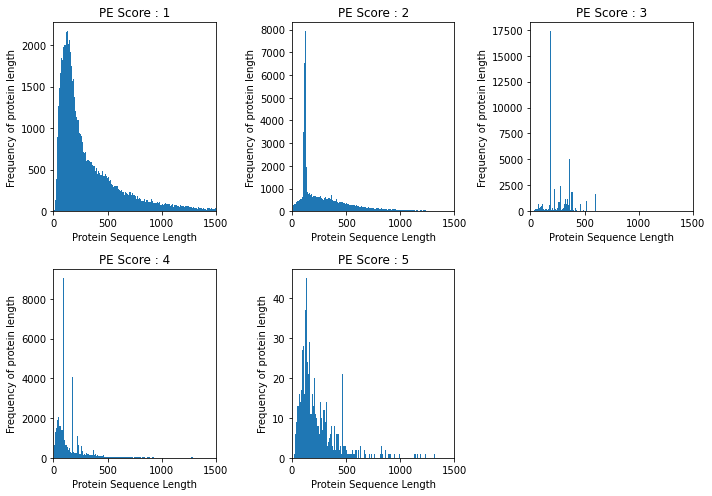

In [ ]:
create_unnormalized_subplot(human_all_table)

# **SUS SCROFA HISTOGRAMS**

This section plots the distributions for all sus scrofa proteins vs. the sus scrofa proteins with "confident" proteins

In [ ]:
#the sus scrofa protein database with ~120,000 proteins
file_name = 'sus_scrofa_all_proteomes.fasta'
length_list = length_of_sequence(file_name)

In [ ]:
len(length_list)

120926

In [ ]:
#the sus scrofa protein database with ~49,000 proteins
file_proteome = 'sus_scrofa_uniprot-proteome_UP000008227.fasta'
length_proteome = length_of_sequence(file_proteome)

In [ ]:
len(length_proteome)

49792

In [ ]:
length_PE_1 = PE_score_length(file_proteome)
len(length_PE_1)

17008

**Probability Density Functions of Sus Scrofa**

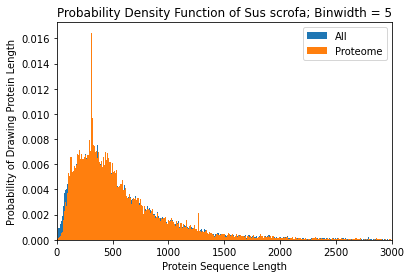

In [ ]:
binwidth = 5
create_normalized_plot(length_list, binwidth)
create_normalized_plot(length_proteome, binwidth)
plt.legend(['All','Proteome'])

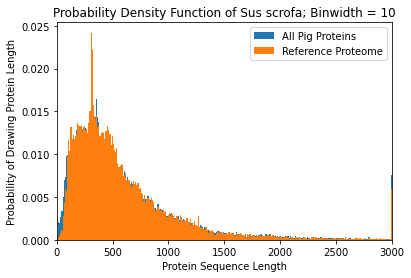

In [ ]:
#probability density function of both the full sus scrofa database and the "confident" sus scrofa database protein sequences
#BIN WIDTH = 10

binwidth = 10
values_all = [3001 if i > 3000 else i for i in length_list] #replaces all length sequences in full DB > 3000 with 3001
values_proteome = [3001 if i > 3000 else i for i in length_proteome] #replaces all length sequences in proteome DB > 3000 with 3001

create_normalized_plot(values_all, binwidth)
create_normalized_plot(values_proteome, binwidth)
plt.legend(['All Pig Proteins','Reference Proteome'])

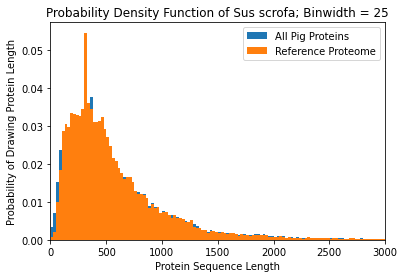

In [ ]:
binwidth = 25
create_normalized_plot(length_list, binwidth)
create_normalized_plot(length_proteome, binwidth)
plt.legend(['All Pig Proteins','Reference Proteome'])

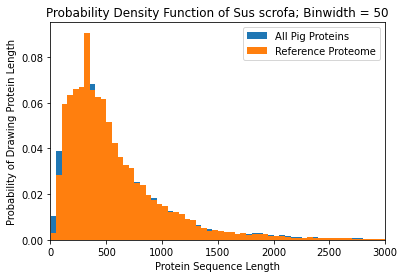

In [ ]:
#probability density function of both the full sus scrofa database and the "confident" sus scrofa database protein sequences
#BIN WIDTH = 50

binwidth = 50
create_normalized_plot(length_list, binwidth)
create_normalized_plot(length_proteome, binwidth)
plt.legend(['All Pig Proteins','Reference Proteome'])

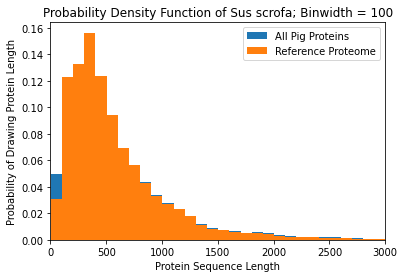

In [ ]:
#probability density function of both the full sus scrofa database and the "confident" sus scrofa database protein sequences
#BIN WIDTH = 100

binwidth = 100
create_normalized_plot(length_list, binwidth)
create_normalized_plot(length_proteome, binwidth)
plt.legend(['All Pig Proteins','Reference Proteome'])

Swiss-prot vs. full:

Text(0, 0.5, 'Probability of protein having length')

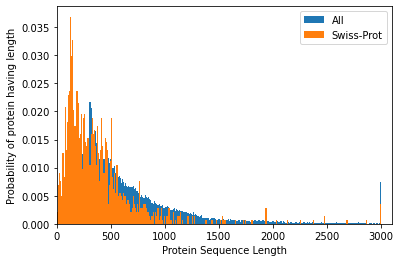

In [ ]:
pig_swiss_prot = swiss_prot_sequences(file_name)
full_length = length_of_sequence(file_name)
binwidth = 10

values_all = [3001 if i > 3000 else i for i in full_length]
values_swiss = [3001 if i > 3000 else i for i in pig_swiss_prot]

plt.hist(values_all, weights = np.zeros_like(values_all)+1./ len(values_all), bins = range(min(values_all), max(values_all) + binwidth, binwidth))
plt.hist(values_swiss, weights = np.zeros_like(values_swiss)+1./ len(values_swiss), bins = range(min(values_swiss), max(values_swiss) + binwidth, binwidth))
plt.xlim(0,3100)

plt.legend(['All','Swiss-Prot'])
plt.xlabel("Protein Sequence Length")
plt.ylabel("Probability of protein having length")


Plot Swiss-prot vs. proteins with PE = 1, PE = 1,2 and PE = 1,2,3

powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)

In [ ]:
length_PE_1 = PE_score_length(file_name, [1]) #extracts from full database the protein lengths with PE = 1
length_PE_2 = PE_score_length(file_name, [1,2]) #extracts from full database the protein lengths with PE = {1,2}
length_PE_3 = PE_score_length(file_name, [1,2,3]) #extracts from full database the protein lengths with PE = {1,2,3}


In [ ]:
PE_1_pig = [3001 if i > 3000 else i for i in length_PE_1]
PE_2_pig = [3001 if i > 3000 else i for i in length_PE_2]
PE_3_pig = [3001 if i > 3000 else i for i in length_PE_3]

In [ ]:
#file_name = 'sus_scrofa_all_proteomes.fasta'
#file_proteome = 'sus_scrofa_uniprot-proteome_UP000008227.fasta'

length_PE_2 = PE_score_length(file_name, [1,2]) #extracts from full database the protein lengths with PE = {1,3}
PE_2_pig = [3001 if i > 3000 else i for i in length_PE_2]

In [ ]:
import difflib

sm=difflib.SequenceMatcher(None,values_swiss,PE_2_pig)
sm.ratio()

0.10264821185694856

Text(0, 0.5, 'Probability of drawing protein with length')

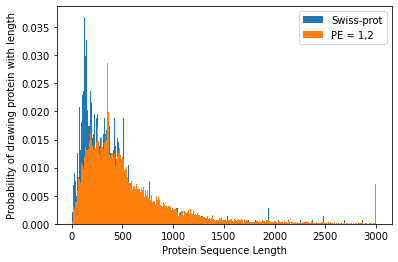

In [ ]:
plt.hist(values_swiss, weights = np.zeros_like(values_swiss)+1./ len(values_swiss), bins = range(min(values_swiss), max(values_swiss) + binwidth, binwidth))
#plt.hist(PE_1_pig, weights = np.zeros_like(PE_1_pig)+1./ len(PE_1_pig), bins = range(min(PE_1_pig), max(PE_1_pig) + binwidth, binwidth))
plt.hist(PE_2_pig, weights = np.zeros_like(PE_2_pig)+1./ len(PE_2_pig), bins = range(min(PE_2_pig), max(PE_2_pig) + binwidth, binwidth))
#plt.hist(PE_3_pig, weights = np.zeros_like(PE_3_pig)+1./ len(PE_3_pig), bins = range(min(PE_3_pig), max(PE_3_pig) + binwidth, binwidth))
plt.legend(['Swiss-prot','PE = 1,2'])
plt.xlabel("Protein Sequence Length")
plt.ylabel("Probability of drawing protein with length")


Objective: Plot the probability density function P(X) for the full sus scrofa database protein sequence lengths vs. a list of proteins from the proteome in sus scrofa where PE = {1}, PE = {1,2} and PE = {1,2,3}

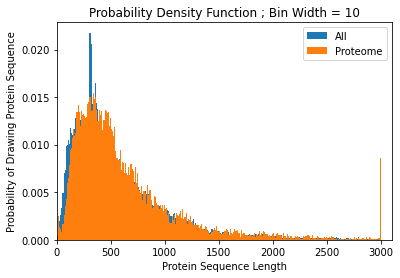

In [ ]:
#probability density function of both the full sus scrofa database and the "confident" sus scrofa database protein sequences
#BIN WIDTH = 10

binwidth = 10
values_all = [3001 if i > 3000 else i for i in length_list] #replaces all length sequences in full DB > 3000 with 3001
values_proteome = [3001 if i > 3000 else i for i in length_PE_1] #replaces all length sequences in proteome DB > 3000 with 3001

plt.hist(values_all, weights=np.zeros_like(values_all)+1./ len(values_all), bins= range(min(values_all), max(values_all) + binwidth, binwidth))
plt.hist(values_proteome, weights=np.zeros_like(values_proteome)+1./ len(values_proteome), bins= range(min(values_proteome), max(values_proteome) + binwidth, binwidth))
plt.xlim(0,3100)
#plt.ylim(0,0.025)
plt.legend(['All','Proteome'])
plt.xlabel("Protein Sequence Length")
plt.ylabel("Probability of Drawing Protein Sequence")
plt.title("Probability Density Function ; Bin Width = 10")
plt.show()

Next, try extracting all PE scores of {1,2,3} from full sus scrofa database and plot it against all protein sequence lengths

In [ ]:
PE_score_full = PE_score_length(file_name)
len(PE_score_full)

66844

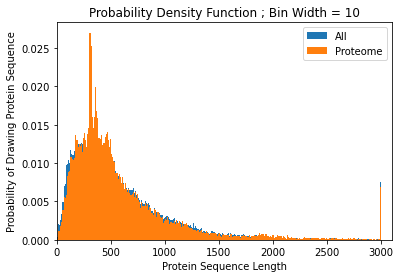

In [ ]:
#probability density function of both the full sus scrofa database and the "confident" sus scrofa database protein sequences
#BIN WIDTH = 10

binwidth = 10
values_all = [3001 if i > 3000 else i for i in length_list] #replaces all length sequences in full DB > 3000 with 3001
values_proteome = [3001 if i > 3000 else i for i in PE_score_full] #replaces all length sequences in proteome DB > 3000 with 3001

plt.hist(values_all, weights=np.zeros_like(values_all)+1./ len(values_all), bins= range(min(values_all), max(values_all) + binwidth, binwidth))
plt.hist(values_proteome, weights=np.zeros_like(values_proteome)+1./ len(values_proteome), bins= range(min(values_proteome), max(values_proteome) + binwidth, binwidth))
plt.xlim(0,3100)
#plt.ylim(0,0.025)
plt.legend(['All','Proteome'])
plt.xlabel("Protein Sequence Length")
plt.ylabel("Probability of Drawing Protein Sequence")
plt.title("Probability Density Function ; Bin Width = 10")
plt.show()

**Unnormalized Plots**

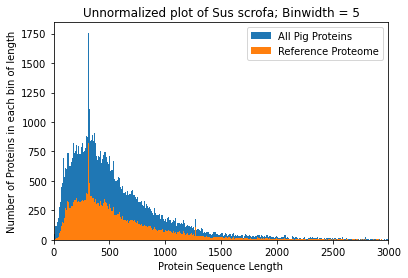

In [ ]:
#number of times a protein sequence has length L of both the full sus scrofa database and the "confident" sus scrofa database protein sequences
#BIN WIDTH = 5

binwidth = 5
create_unnormalized_plot(length_list, binwidth)
create_unnormalized_plot(length_proteome, binwidth)
plt.legend(['All Pig Proteins','Reference Proteome'])

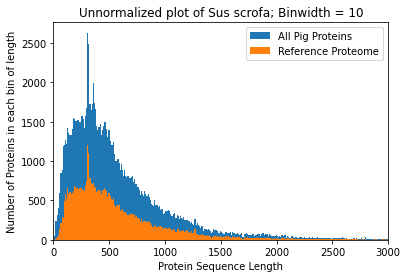

In [ ]:
#number of times a protein sequence has length L of both the full sus scrofa database and the "confident" sus scrofa database protein sequences
#BIN WIDTH = 10

binwidth = 10
create_unnormalized_plot(length_list, binwidth)
create_unnormalized_plot(length_proteome, binwidth)
plt.legend(['All Pig Proteins','Reference Proteome'])

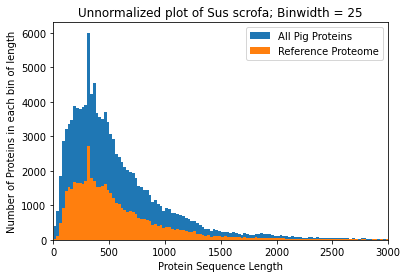

In [ ]:
#number of times a protein sequence has length L of both the full sus scrofa database and the "confident" sus scrofa database protein sequences
#BIN WIDTH = 25

binwidth = 25
create_unnormalized_plot(length_list, binwidth)
create_unnormalized_plot(length_proteome, binwidth)
plt.legend(['All Pig Proteins','Reference Proteome'])

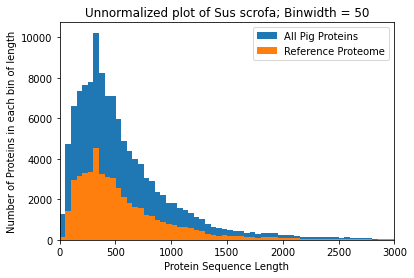

In [ ]:
#number of times a protein sequence has length L of both the full sus scrofa database and the "confident" sus scrofa database protein sequences
#BIN WIDTH = 50

binwidth = 50
create_unnormalized_plot(length_list, binwidth)
create_unnormalized_plot(length_proteome, binwidth)
plt.legend(['All Pig Proteins','Reference Proteome'])

In [ ]:
from statistics import *

mean_all = mean(length_list)
mean_confident = mean(length_confident)

print("Mean of blue: ", mean_all)
print("Mean of orange: ", mean_confident)

Mean of blue:  600.6892727783934
Mean of orange:  587.454711600257


# **HOMO SAPIEN HISTOGRAMS**

Objective: compare all human proteins to Swiss-prot human proteins in proteome

In [ ]:
file_isoform_human = 'all_human_and_isoforms.fasta'
humanFASTA_isoform = fasta_to_table(file_isoform_human)
humanFASTA_isoform

,sptr,accession,organism,Gene Name,length
0,sp,P04439,Homo sapiens,HLA-A,365
1,sp,P04439-2,Homo sapiens,,371
2,sp,P01911,Homo sapiens,HLA-DRB1,266
3,sp,P01889,Homo sapiens,HLA-B,362
4,sp,P31689,Homo sapiens,DNAJA1,397
...,...,...,...,...,...
224135,sp,Q8IUX8,Homo sapiens,EGFL6,553
224136,sp,Q8IUX8-2,Homo sapiens,,554
224137,sp,O15372,Homo sapiens,EIF3H,352
224138,sp,P54852,Homo sapiens,EMP3,163


In [ ]:
file_human_all = 'homo_sapien_all.fasta'
humanFASTA = fasta_to_table(file_human_all)
humanFASTA

,sptr,accession,organism,Gene Name,length
0,sp,P04439,Homo sapiens,HLA-A,365
1,sp,P01911,Homo sapiens,HLA-DRB1,266
2,sp,P01889,Homo sapiens,HLA-B,362
3,sp,P31689,Homo sapiens,DNAJA1,397
4,sp,P08246,Homo sapiens,ELANE,267
...,...,...,...,...,...
202155,sp,Q9P2T1,Homo sapiens,GMPR2,348
202156,sp,Q8IUX8,Homo sapiens,EGFL6,553
202157,sp,O15372,Homo sapiens,EIF3H,352
202158,sp,P54852,Homo sapiens,EMP3,163


In [ ]:
bin_accession_dict = bin_to_accession(humanFASTA)
#bin_accession_dict

In [ ]:
most_entries = max([len(x) for x in list(bin_accession_dict.values())])
most_accessions = None

for key in list(bin_accession_dict.keys()):
  if len(bin_accession_dict[key]) == most_entries:
    most_accessions = bin_accession_dict[key]


In [ ]:
#for hussain
data_peak = {'Accession IDs ' : most_accessions}
data_peak_df = pd.DataFrame(data_peak)
data_peak_df.to_excel("human_peak_accessions.xlsx", index = False)

In [ ]:
isoform_dict = extract_isoforms(humanFASTA_isoform)
isoform_human_length = []
for value in isoform_dict.values():
  isoform_human_length.append(value)


In [ ]:
!ls

all_human_and_isoforms.fasta
homo_sapien_all.fasta
Homo_sapiens_uniprot-proteome_UP000005640.fasta
mus_musculus_all.fasta
mus_musculus_uniprot-proteome_UP000000589.fasta
one_protein_per_gene_proteome
other_api
reactome_uniprot
sus_scrofa_all_proteomes.fasta
sus_scrofa_uniprot-proteome_UP000008227.fasta


In [ ]:
file_human_proteome = 'Homo_sapiens_uniprot-proteome_UP000005640.fasta'
human_proteome = length_of_sequence(file_human_proteome)
len(human_proteome)

78120

In [ ]:
file_human_all = 'homo_sapien_all.fasta'
human_all = length_of_sequence(file_human_all)
len(human_all)

202160

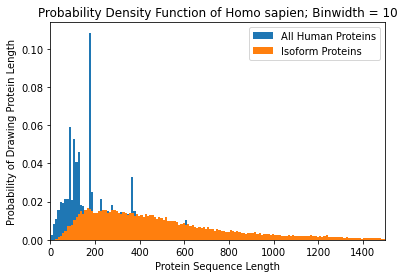

In [ ]:
#probability density function of both the full homo sapien database and the swiss-prot homo sapien protein sequences
#BIN WIDTH = 10

binwidth = 10
xlimit = (0,1500)
create_normalized_plot(human_all, binwidth, xlimit, organism = 'Homo sapien')
#create_normalized_plot(human_proteome, binwidth, xlimit, organism = 'Homo sapien')
#create_normalized_plot(human_proteome, binwidth, xlimit, organism = 'Homo sapien')
create_normalized_plot(isoform_human_length, binwidth, xlimit, organism = 'Homo sapien')
plt.legend(['All Human Proteins','Isoform Proteins'])

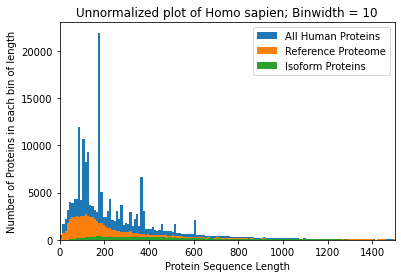

In [ ]:
#BIN WIDTH = 10

binwidth = 10
xlimit = (0,1500)
create_unnormalized_plot(human_all, binwidth, xlimit, organism = 'Homo sapien')
create_unnormalized_plot(human_proteome, binwidth, xlimit, organism = 'Homo sapien')
create_unnormalized_plot(isoform_human_length, binwidth, xlimit, organism = 'Homo sapien')
plt.legend(['All Human Proteins','Reference Proteome', 'Isoform Proteins'])

# **MUS MUSCULUS HISTOGRAMS**

In [ ]:
!ls

homo_sapien_all.fasta
Homo_sapiens_uniprot-proteome_UP000005640.fasta
mus_musculus_all.fasta
mus_musculus_uniprot-proteome_UP000000589.fasta
one_protein_per_gene_proteome
other_api
reactome_uniprot
sus_scrofa_all_proteomes.fasta
sus_scrofa_uniprot-proteome_UP000008227.fasta


In [ ]:
mouse_all_file = 'mus_musculus_all.fasta'
mouse_all_length = length_of_sequence(mouse_all_file) #all sequence lengths
len(mouse_all_length)

86521

In [ ]:
mouse_proteome_file = 'mus_musculus_uniprot-proteome_UP000000589.fasta'
mouse_proteome = length_of_sequence(mouse_proteome_file)
len(mouse_proteome)

55366

All mus musculus proteins vs. proteome proteins

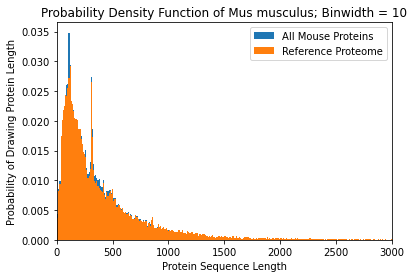

In [ ]:
#BIN WIDTH = 10

binwidth = 10
xlimit = (0,3000)
create_normalized_plot(mouse_all_length, binwidth, xlimit, organism = 'Mus musculus')
create_normalized_plot(mouse_proteome, binwidth, xlimit, organism = 'Mus musculus')
plt.legend(['All Mouse Proteins','Reference Proteome'])

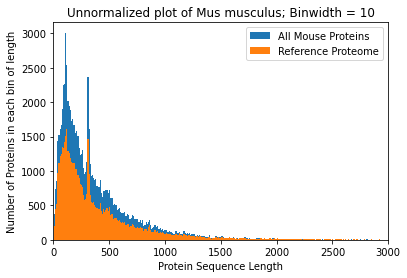

In [ ]:
#BIN WIDTH = 10

binwidth = 10
xlimit = (0,3000)
create_unnormalized_plot(mouse_all_length, binwidth, xlimit, organism = 'Mus musculus')
create_unnormalized_plot(mouse_proteome, binwidth, xlimit, organism = 'Mus musculus')
plt.legend(['All Mouse Proteins','Reference Proteome'])